In [1]:
import scanpy as sc
data_dir = '../../dataset/ad_ge_imputed_Xenium_breast_cancer_sample1_replicate1.h5ad'
adata = sc.read_h5ad(data_dir)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.optim import AdamW
import lightning.pytorch as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPBarlowTwins
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/BarlowTwins.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPBarlowTwins(
        gene_dim=19331,  # 根据你的数据调整
        batch_size=128,  # 根据你的需要调整
        units_encoder=units_encoder,
        CHECKPOINT_PATH=ckpt_path
    )


estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [3]:
# 加载 checkpoint
checkpoint = torch.load(ckpt_path)
estim.model.inner_model.load_state_dict({k.replace('backbone.', ''): v for k, v in checkpoint.items() if 'backbone' in k})

# 5. 添加分类层 (FC 层)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)

In [4]:
# 6. 冻结 encoder 的大部分参数，解冻所有层
for param in estim.model.inner_model.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.inner_model.parameters())[-5:]:
    param.requires_grad = True

In [5]:
# 7. 定义损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
estim.model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)

In [6]:
import pandas as pd
import numpy as np

var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [7]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 17392
匹配的基因列表: {'armc1', 'unc5d', 'fam117a', 'dpm3', 'c1orf141', 'smad9', 'sart3', 'znf628', 'rnf103', 'rnasel', 'akap9', 'tcim', 'gpx7', 'calb1', 'esd', 'scgb1a1', 'ereg', 'dnajc5g', 'hoxc12', 'tmem33', 'neurl1b', 'vsig2', 'mzt1', 'tlk1', 'mettl7a', 'sppl3', 'zc3h7a', 'muc3a', 'mctp2', 'ctsd', 'cd3e', 'obp2a', 'fancf', 'capn7', 'etv7', 'slc25a25', 'lgals8', 'txndc5', 'rab37', 'cfap43', 'gab4', 'ift27', 'gdf7', 'dll4', 'nfat5', 'tpra1', 'scand1', 'abcc8', 'lyn', 'gpalpp1', 'tmem238l', 'unc45b', 'prr19', 'ufl1', 'fam131b', 'pcgf5', 'sptan1', 'or4f6', 'krtap10-7', 'cldn12', 'pkp3', 'ccdc153', 'ptgs2', 'ammecr1l', 'sp140l', 'mark3', 'cldnd2', 'actn3', 'c2orf78', 'golph3l', 'megf8', 'il5ra', 'xirp1', 'tnfrsf12a', 'ddx20', 'scaf4', 'hltf', 'bad', 'zbtb6', 'slc7a3', 'gcnt2', 'rgs18', 'bud31', 'shisa9', 'wdr97', 'neto2', 'bin1', 'klf7', 'lilra1', 'snx12', 'sap30', 'nap1l5', 'rnf41', 'adarb2', 'rrp8', 'rpap2', 'znf716', 'tysnd1', 'trmt61a', 'ccdc201', 'cks2', 'msrb2', 'slc16a12', 'znf

{'aars',
 'ac004593.3',
 'ac005551.1',
 'ac007906.2',
 'ac008397.1',
 'ac008687.4',
 'ac010255.3',
 'ac010325.1',
 'ac011005.1',
 'ac011195.2',
 'ac013470.2',
 'ac015871.1',
 'ac021072.1',
 'ac021097.2',
 'ac025283.2',
 'ac025287.4',
 'ac067752.1',
 'ac072022.2',
 'ac073111.4',
 'ac087498.1',
 'ac090360.1',
 'ac091057.6',
 'ac092835.1',
 'ac093323.1',
 'ac099489.1',
 'ac104389.5',
 'ac113348.1',
 'ac115220.1',
 'ac118549.1',
 'ac119396.1',
 'ac132217.2',
 'ac134684.8',
 'ac138647.1',
 'ac187653.1',
 'ac233723.1',
 'ac236972.4',
 'acpp',
 'adprhl2',
 'adss',
 'adssl1',
 'al032819.3',
 'al109810.2',
 'al121578.2',
 'al135905.2',
 'al160269.1',
 'al162231.1',
 'al162596.1',
 'al353572.3',
 'al354761.1',
 'al391650.1',
 'al445238.1',
 'al451007.3',
 'al590560.2',
 'al603764.2',
 'al845331.2',
 'alg1l',
 'ap002495.1',
 'arih2os',
 'armc4',
 'arse',
 'atp5md',
 'atp5mpl',
 'atp6ap1l',
 'b3gnt10',
 'bhmg1',
 'bx255925.3',
 'bx276092.9',
 'c10orf142',
 'c10orf55',
 'c11orf40',
 'c11orf74',
 'c

In [8]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene al391650.1 not found in all_genes list


Gene yars not found in all_genes list


Gene adprhl2 not found in all_genes list


Gene tctex1d4 not found in all_genes list


Gene tctex1d1 not found in all_genes list
Gene wdr78 not found in all_genes list
Gene hhla3 not found in all_genes list


Gene ac118549.1 not found in all_genes list
Gene wdr63 not found in all_genes list


Gene kiaa1324 not found in all_genes list
Gene sars not found in all_genes list


Gene hist2h2be not found in all_genes list


Gene al162596.1 not found in all_genes list
Gene lor not found in all_genes list


Gene c1orf61 not found in all_genes list


Gene al590560.2 not found in all_genes list


Gene rgs5 not found in all_genes list
Gene dusp27 not found in all_genes list


Gene eprs not found in all_genes list
Gene marc2 not found in all_genes list
Gene marc1 not found in all_genes list


Gene h3f3a not found in all_genes list
Gene hist3h3 not found in all_genes list
Gene hist3h2a not found in all_genes list
Gene hist3h2bb not found in all_genes list


Gene al109810.2 not found in all_genes list
Gene tbce not found in all_genes list


Gene adss not found in all_genes list
Gene al451007.3 not found in all_genes list
Gene gcsaml-as1 not found in all_genes list


Gene mycnos not found in all_genes list
Gene fam49a not found in all_genes list


Gene c2orf91 not found in all_genes list


Gene igkc not found in all_genes list
Gene al845331.2 not found in all_genes list
Gene ac092835.1 not found in all_genes list


Gene kiaa1211l not found in all_genes list


Gene dars not found in all_genes list


Gene march7 not found in all_genes list


Gene pde11a not found in all_genes list


Gene dirc1 not found in all_genes list


Gene march4 not found in all_genes list


Gene c2orf83 not found in all_genes list


Gene arih2os not found in all_genes list
Gene qars not found in all_genes list
Gene ccdc36 not found in all_genes list


Gene cyb561d2 not found in all_genes list


Gene c3orf67 not found in all_genes list


Gene maats1 not found in all_genes list


Gene alg1l not found in all_genes list
Gene kiaa1257 not found in all_genes list


Gene h1fx not found in all_genes list
Gene h1foo not found in all_genes list
Gene acpp not found in all_genes list


Gene slc66a1l not found in all_genes list


Gene terc not found in all_genes list


Gene ccdc39 not found in all_genes list


Gene ac072022.2 not found in all_genes list


Gene tctex1d2 not found in all_genes list


Gene ac093323.1 not found in all_genes list


Gene kiaa1211 not found in all_genes list


Gene h2afz not found in all_genes list


Gene tmem155 not found in all_genes list


Gene march1 not found in all_genes list
Gene fam218a not found in all_genes list


Gene march6 not found in all_genes list
Gene march11 not found in all_genes list
Gene h3.y not found in all_genes list


Gene tars not found in all_genes list


Gene c5orf67 not found in all_genes list


Gene atp6ap1l not found in all_genes list


Gene c5orf30 not found in all_genes list


Gene ac010255.3 not found in all_genes list
Gene march3 not found in all_genes list


Gene h2afy not found in all_genes list


Gene tmem173 not found in all_genes list
Gene hars not found in all_genes list


Gene lars not found in all_genes list


Gene rars not found in all_genes list


Gene ac113348.1 not found in all_genes list
Gene c5orf60 not found in all_genes list


Gene c6orf201 not found in all_genes list


Gene hist1h1a not found in all_genes list
Gene hist1h4b not found in all_genes list
Gene hist1h2bb not found in all_genes list
Gene hist1h1c not found in all_genes list
Gene hist1h4c not found in all_genes list
Gene hist1h2ac not found in all_genes list
Gene hist1h1e not found in all_genes list
Gene hist1h4e not found in all_genes list
Gene hist1h2bg not found in all_genes list
Gene hist1h2ae not found in all_genes list
Gene hist1h3e not found in all_genes list
Gene hist1h1d not found in all_genes list
Gene hist1h4g not found in all_genes list
Gene hist1h2bh not found in all_genes list
Gene hist1h3g not found in all_genes list
Gene hist1h2ag not found in all_genes list
Gene hist1h4i not found in all_genes list
Gene hist1h2ai not found in all_genes list
Gene hist1h3h not found in all_genes list
Gene hist1h4j not found in all_genes list
Gene hist1h2bn not found in all_genes list
Gene hist1h2ak not found in all_genes list
Gene hist1h1b not found in all_genes list


Gene znrd1 not found in all_genes list


Gene vars not found in all_genes list
Gene snhg32 not found in all_genes list


Gene c6orf223 not found in all_genes list
Gene defb133 not found in all_genes list


Gene ick not found in all_genes list
Gene al135905.2 not found in all_genes list


Gene fgfr1op not found in all_genes list
Gene tcte3 not found in all_genes list
Gene ac187653.1 not found in all_genes list


Gene ac013470.2 not found in all_genes list


Gene twistnb not found in all_genes list


Gene ac004593.3 not found in all_genes list


Gene gars not found in all_genes list


Gene trgc2 not found in all_genes list
Gene trgjp2 not found in all_genes list
Gene trgc1 not found in all_genes list
Gene trgjp1 not found in all_genes list


Gene ac115220.1 not found in all_genes list


Gene kiaa1324l not found in all_genes list


Gene castor3 not found in all_genes list


Gene c7orf77 not found in all_genes list


Gene ac011005.1 not found in all_genes list


Gene trbc1 not found in all_genes list
Gene trbc2 not found in all_genes list


Gene sspo not found in all_genes list
Gene ac073111.4 not found in all_genes list


Gene ac021097.2 not found in all_genes list


Gene wdr60 not found in all_genes list
Gene ac134684.8 not found in all_genes list


Gene pinx1 not found in all_genes list


Gene impad1 not found in all_genes list


Gene wdyhv1 not found in all_genes list
Gene fam49b not found in all_genes list


Gene ac138647.1 not found in all_genes list


Gene tsta3 not found in all_genes list


Gene dock8-as1 not found in all_genes list


Gene c9orf92 not found in all_genes list


Gene al162231.1 not found in all_genes list


Gene fam122a not found in all_genes list


Gene al353572.3 not found in all_genes list
Gene iars not found in all_genes list


Gene c9orf129 not found in all_genes list
Gene al160269.1 not found in all_genes list


Gene tmem246 not found in all_genes list


Gene palm2-akap2 not found in all_genes list


Gene znf883 not found in all_genes list


Gene dec1 not found in all_genes list
Gene b3gnt10 not found in all_genes list


Gene wdr34 not found in all_genes list


Gene al354761.1 not found in all_genes list


Gene bx255925.3 not found in all_genes list


Gene mir1915hg not found in all_genes list


Gene armc4 not found in all_genes list


Gene c10orf142 not found in all_genes list
Gene march8 not found in all_genes list


Gene ac067752.1 not found in all_genes list
Gene kif1bp not found in all_genes list


Gene h2afy2 not found in all_genes list


Gene c10orf55 not found in all_genes list
Gene dupd1 not found in all_genes list


Gene march5 not found in all_genes list


Gene atp5md not found in all_genes list


Gene al603764.2 not found in all_genes list


Gene pano1 not found in all_genes list


Gene ac132217.2 not found in all_genes list
Gene cars not found in all_genes list


Gene c11orf40 not found in all_genes list
Gene ac104389.5 not found in all_genes list


Gene st5 not found in all_genes list
Gene mrvi1 not found in all_genes list


Gene c11orf74 not found in all_genes list


Gene or5r1 not found in all_genes list


Gene ap002495.1 not found in all_genes list


Gene card16 not found in all_genes list
Gene card17 not found in all_genes list


Gene c11orf88 not found in all_genes list


Gene ccdc84 not found in all_genes list
Gene h2afx not found in all_genes list


Gene hist4h4 not found in all_genes list
Gene h2afj not found in all_genes list


Gene lrmp not found in all_genes list
Gene casc1 not found in all_genes list


Gene h3f3c not found in all_genes list


Gene h1fnt not found in all_genes list


Gene c12orf81 not found in all_genes list
Gene grasp not found in all_genes list


Gene ac021072.1 not found in all_genes list
Gene c12orf10 not found in all_genes list


Gene mars not found in all_genes list
Gene slc26a10 not found in all_genes list
Gene march9 not found in all_genes list


Gene cllu1os not found in all_genes list
Gene c12orf74 not found in all_genes list


Gene c12orf49 not found in all_genes list


Gene wdr66 not found in all_genes list


Gene spata13 not found in all_genes list


Gene spert not found in all_genes list


Gene al445238.1 not found in all_genes list


Gene trdc not found in all_genes list
Gene trac not found in all_genes list


Gene elmsan1 not found in all_genes list


Gene c14orf177 not found in all_genes list
Gene wars not found in all_genes list


Gene atp5mpl not found in all_genes list
Gene adssl1 not found in all_genes list


Gene igha2 not found in all_genes list
Gene ighe not found in all_genes list
Gene igha1 not found in all_genes list
Gene ighg1 not found in all_genes list
Gene ighg3 not found in all_genes list
Gene ighd not found in all_genes list
Gene ighm not found in all_genes list
Gene fam30a not found in all_genes list
Gene golga8m not found in all_genes list


Gene ac091057.6 not found in all_genes list


Gene c15orf41 not found in all_genes list
Gene linc02694 not found in all_genes list


Gene casc4 not found in all_genes list


Gene ct62 not found in all_genes list


Gene ac015871.1 not found in all_genes list


Gene spata8 not found in all_genes list
Gene fam169b not found in all_genes list


Gene tarsl2 not found in all_genes list
Gene tmem8a not found in all_genes list


Gene al032819.3 not found in all_genes list


Gene ac025283.2 not found in all_genes list


Gene ac099489.1 not found in all_genes list
Gene fopnl not found in all_genes list


Gene kiaa0556 not found in all_genes list


Gene c16orf58 not found in all_genes list


Gene ac007906.2 not found in all_genes list


Gene fam192a not found in all_genes list


Gene lrrc29 not found in all_genes list


Gene aars not found in all_genes list


Gene kars not found in all_genes list
Gene ac025287.4 not found in all_genes list


Gene fam92b not found in all_genes list


Gene cenpbd1 not found in all_genes list


Gene ac087498.1 not found in all_genes list


Gene ac233723.1 not found in all_genes list


Gene trim16l not found in all_genes list
Gene linc02693 not found in all_genes list


Gene slfn12l not found in all_genes list


Gene tmem99 not found in all_genes list


Gene ttc25 not found in all_genes list


Gene c17orf53 not found in all_genes list


Gene ac011195.2 not found in all_genes list


Gene march10 not found in all_genes list


Gene h3f3b not found in all_genes list


Gene eloa3 not found in all_genes list


Gene nars not found in all_genes list


Gene ac090360.1 not found in all_genes list


Gene ac005551.1 not found in all_genes list


Gene ac119396.1 not found in all_genes list


Gene march2 not found in all_genes list


Gene ccdc151 not found in all_genes list


Gene c19orf57 not found in all_genes list


Gene ac008397.1 not found in all_genes list


Gene kiaa0355 not found in all_genes list


Gene cntd2 not found in all_genes list


Gene cd3eap not found in all_genes list
Gene bhmg1 not found in all_genes list


Gene ppp5d1 not found in all_genes list


Gene ccdc114 not found in all_genes list


Gene ac008687.4 not found in all_genes list
Gene ccdc155 not found in all_genes list


Gene ac010325.1 not found in all_genes list
Gene c19orf48 not found in all_genes list


Gene siglec5 not found in all_genes list


Gene gdf5os not found in all_genes list


Gene tmem189 not found in all_genes list


Gene fp565260.1 not found in all_genes list


Gene iglc1 not found in all_genes list
Gene iglc7 not found in all_genes list


Gene lrp5l not found in all_genes list


Gene elfn2 not found in all_genes list
Gene h1f0 not found in all_genes list


Gene z82206.1 not found in all_genes list


Gene arse not found in all_genes list


Gene cxorf21 not found in all_genes list
Gene hypm not found in all_genes list
Gene al121578.2 not found in all_genes list


Gene bx276092.9 not found in all_genes list


Gene nxf5 not found in all_genes list
Gene glra4 not found in all_genes list
Gene tmsb15b not found in all_genes list
Gene h2bfwt not found in all_genes list
Gene h2bfm not found in all_genes list


Gene pih1d3 not found in all_genes list


Gene cxorf56 not found in all_genes list


Gene fam122b not found in all_genes list
Gene fam122c not found in all_genes list


Gene cxorf40a not found in all_genes list
Gene ac236972.4 not found in all_genes list


Gene prky not found in all_genes list


In [9]:
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [10]:
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.inner_model(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.inner_model(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [12]:
torch.cuda.empty_cache()

In [13]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")

Epoch 1, Train Loss: 1.0449931256002332, Validation Loss: 0.9697410515722285
Validation loss improved to 0.9697410515722285, resetting patience.


Epoch 2, Train Loss: 0.9341386486502254, Validation Loss: 0.8958781966703192
Validation loss improved to 0.8958781966703192, resetting patience.


Epoch 3, Train Loss: 0.9067878056974972, Validation Loss: 0.9068477153778076
No improvement in validation loss. Patience counter: 1/20


Epoch 4, Train Loss: 0.8936513723371335, Validation Loss: 0.8676885808179826
Validation loss improved to 0.8676885808179826, resetting patience.


Epoch 5, Train Loss: 0.8851181253758391, Validation Loss: 0.8821228134450574
No improvement in validation loss. Patience counter: 1/20


Epoch 6, Train Loss: 0.8794780071654351, Validation Loss: 0.8563622647735674
Validation loss improved to 0.8563622647735674, resetting patience.


Epoch 7, Train Loss: 0.875757308047841, Validation Loss: 0.8711318419064362
No improvement in validation loss. Patience counter: 1/20


Epoch 8, Train Loss: 0.8726175327446466, Validation Loss: 0.8762522140130173
No improvement in validation loss. Patience counter: 2/20


Epoch 9, Train Loss: 0.8690977453016767, Validation Loss: 0.8722971883522073
No improvement in validation loss. Patience counter: 3/20


Epoch 10, Train Loss: 0.8623312175403753, Validation Loss: 0.8610687204423895
No improvement in validation loss. Patience counter: 4/20


Epoch 11, Train Loss: 0.8626464991657822, Validation Loss: 0.8585240132917608
No improvement in validation loss. Patience counter: 5/20


Epoch 12, Train Loss: 0.8600370732657531, Validation Loss: 0.8460929856687633
Validation loss improved to 0.8460929856687633, resetting patience.


Epoch 13, Train Loss: 0.8581649441604781, Validation Loss: 0.8736777099861106
No improvement in validation loss. Patience counter: 1/20


Epoch 14, Train Loss: 0.857110984769522, Validation Loss: 0.8473402213324145
No improvement in validation loss. Patience counter: 2/20


Epoch 15, Train Loss: 0.8558288175036445, Validation Loss: 0.8499700160801108
No improvement in validation loss. Patience counter: 3/20


Epoch 16, Train Loss: 0.854364529868876, Validation Loss: 0.8492561660442256
No improvement in validation loss. Patience counter: 4/20


Epoch 17, Train Loss: 0.8521487340818044, Validation Loss: 0.8430646431022489
Validation loss improved to 0.8430646431022489, resetting patience.


Epoch 18, Train Loss: 0.8509523003059795, Validation Loss: 0.8373154480445203
Validation loss improved to 0.8373154480445203, resetting patience.


Epoch 19, Train Loss: 0.8515972302240484, Validation Loss: 0.8420364747797777
No improvement in validation loss. Patience counter: 1/20


Epoch 20, Train Loss: 0.8496209601820943, Validation Loss: 0.8771159385666629
No improvement in validation loss. Patience counter: 2/20


Epoch 21, Train Loss: 0.8480999975552486, Validation Loss: 0.8645753167607457
No improvement in validation loss. Patience counter: 3/20


Epoch 22, Train Loss: 0.845283993059254, Validation Loss: 0.8515859576046164
No improvement in validation loss. Patience counter: 4/20


Epoch 23, Train Loss: 0.8460300316737888, Validation Loss: 0.8455778820260527
No improvement in validation loss. Patience counter: 5/20


Epoch 24, Train Loss: 0.8446379087719262, Validation Loss: 0.855819912731345
No improvement in validation loss. Patience counter: 6/20


Epoch 25, Train Loss: 0.8454658716981966, Validation Loss: 0.8427453128819539
No improvement in validation loss. Patience counter: 7/20


Epoch 26, Train Loss: 0.8435210844010829, Validation Loss: 0.8457500078351364
No improvement in validation loss. Patience counter: 8/20


Epoch 27, Train Loss: 0.8418083424661674, Validation Loss: 0.8475270480068807
No improvement in validation loss. Patience counter: 9/20


Epoch 28, Train Loss: 0.84194276269225, Validation Loss: 0.8357801842810538
Validation loss improved to 0.8357801842810538, resetting patience.


Epoch 29, Train Loss: 0.8407224835523592, Validation Loss: 0.8523082521361143
No improvement in validation loss. Patience counter: 1/20


Epoch 30, Train Loss: 0.8402391893541631, Validation Loss: 0.8518315565767627
No improvement in validation loss. Patience counter: 2/20


Epoch 31, Train Loss: 0.8399531767259236, Validation Loss: 0.8268467039626262
Validation loss improved to 0.8268467039626262, resetting patience.


Epoch 32, Train Loss: 0.8411668722146477, Validation Loss: 0.8505282423217889
No improvement in validation loss. Patience counter: 1/20


Epoch 33, Train Loss: 0.8385654358692418, Validation Loss: 0.8307209208532034
No improvement in validation loss. Patience counter: 2/20


Epoch 34, Train Loss: 0.839464339750265, Validation Loss: 0.8441916280591548
No improvement in validation loss. Patience counter: 3/20


Epoch 35, Train Loss: 0.8382170306181855, Validation Loss: 0.8478500446692336
No improvement in validation loss. Patience counter: 4/20


Epoch 36, Train Loss: 0.8365929516961632, Validation Loss: 0.8311949366240332
No improvement in validation loss. Patience counter: 5/20


Epoch 37, Train Loss: 0.8365550452847367, Validation Loss: 0.8562799483386393
No improvement in validation loss. Patience counter: 6/20


Epoch 38, Train Loss: 0.8368532498547714, Validation Loss: 0.8399094564055428
No improvement in validation loss. Patience counter: 7/20


Epoch 39, Train Loss: 0.8359803458704148, Validation Loss: 0.840588625009895
No improvement in validation loss. Patience counter: 8/20


Epoch 40, Train Loss: 0.8357781336393232, Validation Loss: 0.832212674738792
No improvement in validation loss. Patience counter: 9/20


Epoch 41, Train Loss: 0.8349975328689567, Validation Loss: 0.8424050260316297
No improvement in validation loss. Patience counter: 10/20


Epoch 42, Train Loss: 0.8360546766283206, Validation Loss: 0.8392127119950231
No improvement in validation loss. Patience counter: 11/20


Epoch 43, Train Loss: 0.8350990561683194, Validation Loss: 0.8341790219853977
No improvement in validation loss. Patience counter: 12/20


Epoch 44, Train Loss: 0.8326599518068476, Validation Loss: 0.8401176511938802
No improvement in validation loss. Patience counter: 13/20


Epoch 45, Train Loss: 0.8338341640880684, Validation Loss: 0.8470748774896418
No improvement in validation loss. Patience counter: 14/20


Epoch 46, Train Loss: 0.8327455404407318, Validation Loss: 0.8288304427553554
No improvement in validation loss. Patience counter: 15/20


Epoch 47, Train Loss: 0.8318394682895643, Validation Loss: 0.8388248318948116
No improvement in validation loss. Patience counter: 16/20


Epoch 48, Train Loss: 0.8322962989994124, Validation Loss: 0.8527448679589983
No improvement in validation loss. Patience counter: 17/20


Epoch 49, Train Loss: 0.8317903817219412, Validation Loss: 0.8241006641218505
Validation loss improved to 0.8241006641218505, resetting patience.


Epoch 50, Train Loss: 0.832880099030102, Validation Loss: 0.8474645602521558
No improvement in validation loss. Patience counter: 1/20


Epoch 51, Train Loss: 0.8312112727975534, Validation Loss: 0.824799499233362
No improvement in validation loss. Patience counter: 2/20


Epoch 52, Train Loss: 0.8315793974467093, Validation Loss: 0.8321835144522226
No improvement in validation loss. Patience counter: 3/20


Epoch 53, Train Loss: 0.8312764462237784, Validation Loss: 0.8384811654308726
No improvement in validation loss. Patience counter: 4/20


Epoch 54, Train Loss: 0.8328960211318562, Validation Loss: 0.8247354097172693
No improvement in validation loss. Patience counter: 5/20


Epoch 55, Train Loss: 0.8296582647528264, Validation Loss: 0.8540635375202005
No improvement in validation loss. Patience counter: 6/20


Epoch 56, Train Loss: 0.8309116096018706, Validation Loss: 0.83627196465652
No improvement in validation loss. Patience counter: 7/20


Epoch 57, Train Loss: 0.8311177245412257, Validation Loss: 0.8415539863751019
No improvement in validation loss. Patience counter: 8/20


Epoch 58, Train Loss: 0.8285015513045076, Validation Loss: 0.8296106421402868
No improvement in validation loss. Patience counter: 9/20


Epoch 59, Train Loss: 0.8295208031964977, Validation Loss: 0.822682166765184
Validation loss improved to 0.822682166765184, resetting patience.


Epoch 60, Train Loss: 0.8303666000532429, Validation Loss: 0.8330360654041852
No improvement in validation loss. Patience counter: 1/20


Epoch 61, Train Loss: 0.8298364146602439, Validation Loss: 0.8355905906803112
No improvement in validation loss. Patience counter: 2/20


Epoch 62, Train Loss: 0.8300215529200817, Validation Loss: 0.8280628486938283
No improvement in validation loss. Patience counter: 3/20


Epoch 63, Train Loss: 0.830719449161704, Validation Loss: 0.825587758255489
No improvement in validation loss. Patience counter: 4/20


Epoch 64, Train Loss: 0.828626590876278, Validation Loss: 0.8227508930385415
No improvement in validation loss. Patience counter: 5/20


Epoch 65, Train Loss: 0.8288144814033135, Validation Loss: 0.8198398675410276
Validation loss improved to 0.8198398675410276, resetting patience.


Epoch 66, Train Loss: 0.8294671608991353, Validation Loss: 0.8308592263212059
No improvement in validation loss. Patience counter: 1/20


Epoch 67, Train Loss: 0.8287440246876029, Validation Loss: 0.8327606471661989
No improvement in validation loss. Patience counter: 2/20


Epoch 68, Train Loss: 0.8272631166742258, Validation Loss: 0.8318120353112971
No improvement in validation loss. Patience counter: 3/20


Epoch 69, Train Loss: 0.8280838673410852, Validation Loss: 0.8199661122965933
No improvement in validation loss. Patience counter: 4/20


Epoch 70, Train Loss: 0.8286794850639269, Validation Loss: 0.8298526218699925
No improvement in validation loss. Patience counter: 5/20


Epoch 71, Train Loss: 0.8273469560286578, Validation Loss: 0.8418703067121167
No improvement in validation loss. Patience counter: 6/20


Epoch 72, Train Loss: 0.8266341721310335, Validation Loss: 0.8185128563551733
Validation loss improved to 0.8185128563551733, resetting patience.


Epoch 73, Train Loss: 0.8275403938457078, Validation Loss: 0.830034049634401
No improvement in validation loss. Patience counter: 1/20


Epoch 74, Train Loss: 0.8261254722646119, Validation Loss: 0.8283237227933661
No improvement in validation loss. Patience counter: 2/20


Epoch 75, Train Loss: 0.826156037727732, Validation Loss: 0.8434756195484684
No improvement in validation loss. Patience counter: 3/20


Epoch 76, Train Loss: 0.8294782089252098, Validation Loss: 0.8401330978737265
No improvement in validation loss. Patience counter: 4/20


Epoch 77, Train Loss: 0.8262379732072224, Validation Loss: 0.8240988617621098
No improvement in validation loss. Patience counter: 5/20


Epoch 78, Train Loss: 0.8286802309011322, Validation Loss: 0.8290096288405094
No improvement in validation loss. Patience counter: 6/20


Epoch 79, Train Loss: 0.8268057003390036, Validation Loss: 0.8427009001601166
No improvement in validation loss. Patience counter: 7/20


Epoch 80, Train Loss: 0.8264478437261644, Validation Loss: 0.8484720984086167
No improvement in validation loss. Patience counter: 8/20


Epoch 81, Train Loss: 0.8254790855389015, Validation Loss: 0.8390268386923118
No improvement in validation loss. Patience counter: 9/20


Epoch 82, Train Loss: 0.8269822400769377, Validation Loss: 0.8310947896260296
No improvement in validation loss. Patience counter: 10/20


Epoch 83, Train Loss: 0.826060759410879, Validation Loss: 0.8191979705984822
No improvement in validation loss. Patience counter: 11/20


Epoch 84, Train Loss: 0.8266619121197262, Validation Loss: 0.8317009035100792
No improvement in validation loss. Patience counter: 12/20


Epoch 85, Train Loss: 0.8267339744599037, Validation Loss: 0.8299131532610976
No improvement in validation loss. Patience counter: 13/20


Epoch 86, Train Loss: 0.8257894925042695, Validation Loss: 0.8324986048761358
No improvement in validation loss. Patience counter: 14/20


Epoch 87, Train Loss: 0.8254746299943113, Validation Loss: 0.8262553919995497
No improvement in validation loss. Patience counter: 15/20


Epoch 88, Train Loss: 0.8277228901848555, Validation Loss: 0.8346265309353165
No improvement in validation loss. Patience counter: 16/20


Epoch 89, Train Loss: 0.8244828311381517, Validation Loss: 0.8311622514942576
No improvement in validation loss. Patience counter: 17/20


Epoch 90, Train Loss: 0.826515040431407, Validation Loss: 0.8617411443424708
No improvement in validation loss. Patience counter: 18/20


Epoch 91, Train Loss: 0.8271833840019043, Validation Loss: 0.8267828413677699
No improvement in validation loss. Patience counter: 19/20


Epoch 92, Train Loss: 0.8268478938047662, Validation Loss: 0.8340866257091464
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 92.
Loaded best model weights based on validation loss.


In [14]:
import os

# 定义保存路径
save_dir = './imputed_xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'BT_FT_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


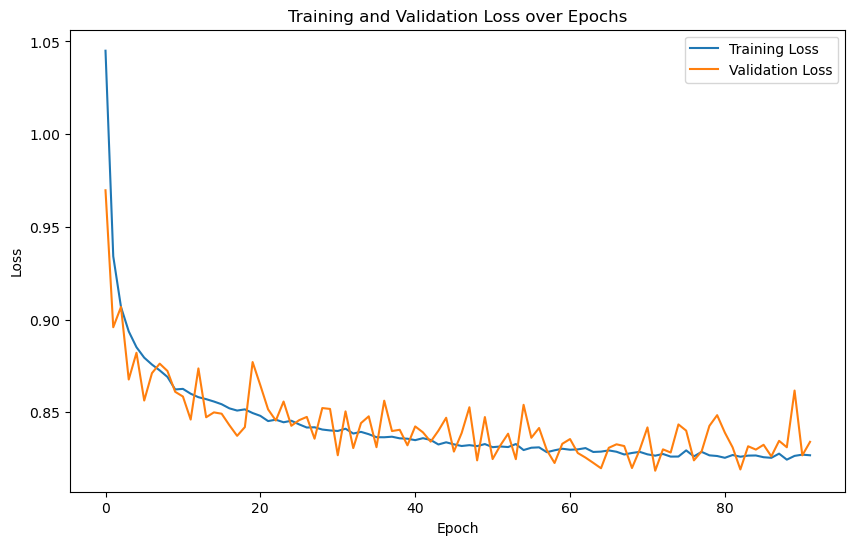

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/imputed_Xenium_breast_cancer_barlow_twins_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，300 dpi
plt.savefig(f'../loss_curve_fig/imputed_Xenium_breast_cancer_barlow_twins_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，300 dpi

plt.show()


In [16]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.inner_model(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.inner_model(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [17]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.7158978026781102
Weighted F1 Score: 0.7128892701407624
Macro F1 Score: 0.5878270123047437
Random Guess Accuracy: 0.1320247177116093
                         precision    recall  f1-score   support

                B_Cells       0.69      0.83      0.75       772
           CD4+_T_Cells       0.49      0.57      0.52      1286
           CD8+_T_Cells       0.53      0.55      0.54      1026
                 DCIS_1       0.74      0.73      0.73      1937
                 DCIS_2       0.58      0.59      0.59      1746
            Endothelial       0.83      0.87      0.85      1348
              IRF7+_DCs       0.82      0.78      0.80        74
         Invasive_Tumor       0.81      0.83      0.82      5230
             LAMP3+_DCs       0.57      0.53      0.55        49
          Macrophages_1       0.69      0.75      0.72      1692
          Macrophages_2       0.51      0.47      0.49       223
             Mast_Cells       0.59      0.46      0.52    

In [18]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.inner_model(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_BT_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'BT_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'BT_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'BT_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'BT_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'BT_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [19]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "imputed_Xenium_breast_cancer_sample1_replicate1_barlow_twins_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['imputed_xenium_breast_cancer_sample1_replicate1'],
    'method': [re.search(r'replicate1_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
1.045	0.970	72	0.819	0.588	0.713	0.716
